In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, events_from_annotations, viz
import mne.channels as channels
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne import set_log_level
set_log_level("WARNING")


# 1. Load the data

- subject: the person on which we picked the data and put the EEG
- [runs](https://mne.tools/stable/generated/mne.datasets.eegbci.load_data.html#mne.datasets.eegbci.load_data) :

|run|task|
|--|--|
|1|Baseline, eyes open|
|2|Baseline, eyes closed|
|3, 7, 11|Motor execution: left vs right hand|
|4, 8, 12|Motor imagery: left vs right hand|
|5, 9, 13|Motor execution: hands vs feet|
|6, 10, 14|Motor imagery: hands vs feet|

In [2]:
subject = 1
runs = [3, 7, 11]  # motor imagery: hands vs feet

raw_fnames = eegbci.load_data(subject, runs, path= "./mne_data")
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
saved_raw = raw.copy()
eegbci.standardize(raw)

### 1.a Inspect the data
This raw data contains all the necessary info about one particular experiment on one particular patient:

In [3]:
raw

<RawEDF | S001R03.edf, 64 x 60000 (375.0 s), ~29.4 MB, data loaded>

### 1.b Select the montage
le montage, en gros, c'est la maniere dont on ete placés les electrodes (channels) sur la tête du sujet.\
Mais alors lequel choisi?

In [4]:
print(channels.get_builtin_montages())

['standard_1005', 'standard_1020', 'standard_alphabetic', 'standard_postfixed', 'standard_prefixed', 'standard_primed', 'biosemi16', 'biosemi32', 'biosemi64', 'biosemi128', 'biosemi160', 'biosemi256', 'easycap-M1', 'easycap-M10', 'EGI_256', 'GSN-HydroCel-32', 'GSN-HydroCel-64_1.0', 'GSN-HydroCel-65_1.0', 'GSN-HydroCel-128', 'GSN-HydroCel-129', 'GSN-HydroCel-256', 'GSN-HydroCel-257', 'mgh60', 'mgh70', 'artinis-octamon', 'artinis-brite23', 'brainproducts-RNP-BA-128']


Ex de montages:

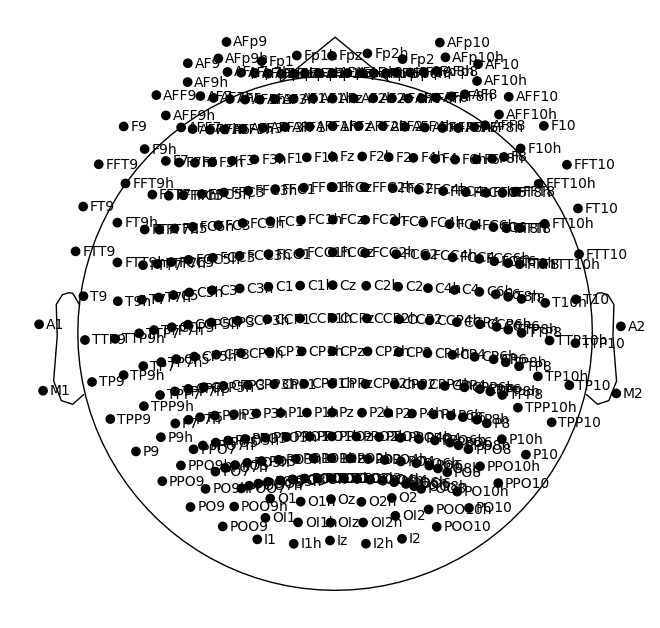

In [5]:
montage = make_standard_montage('standard_1005')
montage.plot()
plt.show()

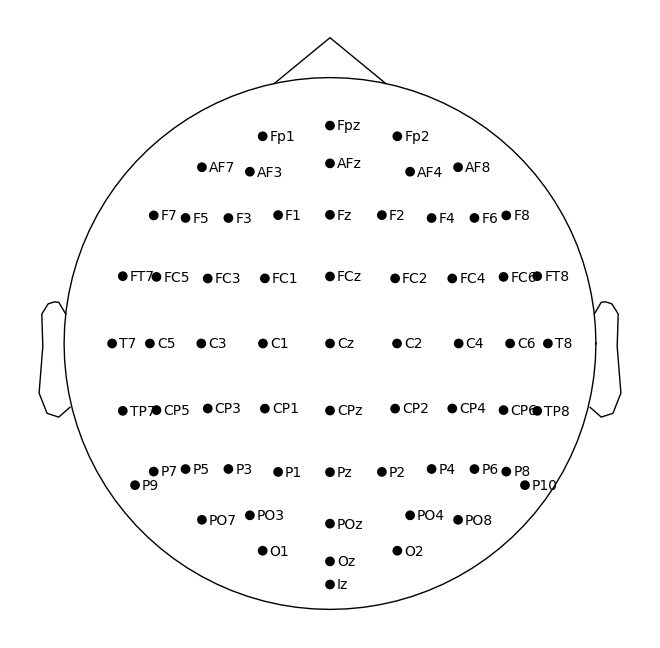

In [6]:
montage = make_standard_montage('biosemi64')
montage.plot()
plt.show()

`biosemi64`, `standard_1020` sont deux montages connus pour leurs placements d'electrodes pres de la zone "sensorimotor" du cortex. 

Choisissons donc l'un d'entre eux, **biosemi64**:

In [7]:
montage = make_standard_montage('biosemi64')
raw = raw.set_montage(montage, on_missing='ignore')

### 1.c Plot the data:

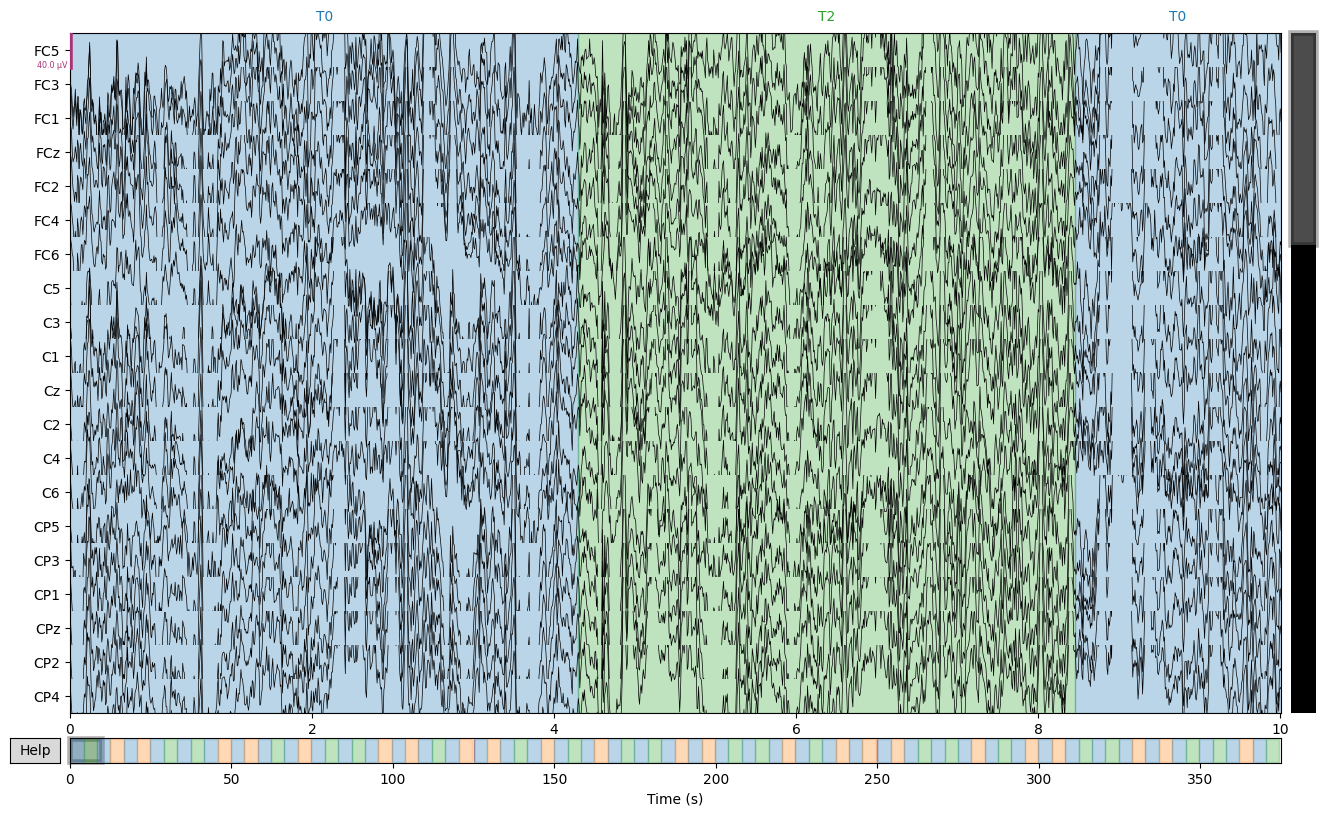

In [8]:
_ = raw.plot()

Let's make it a bit nicer to look:

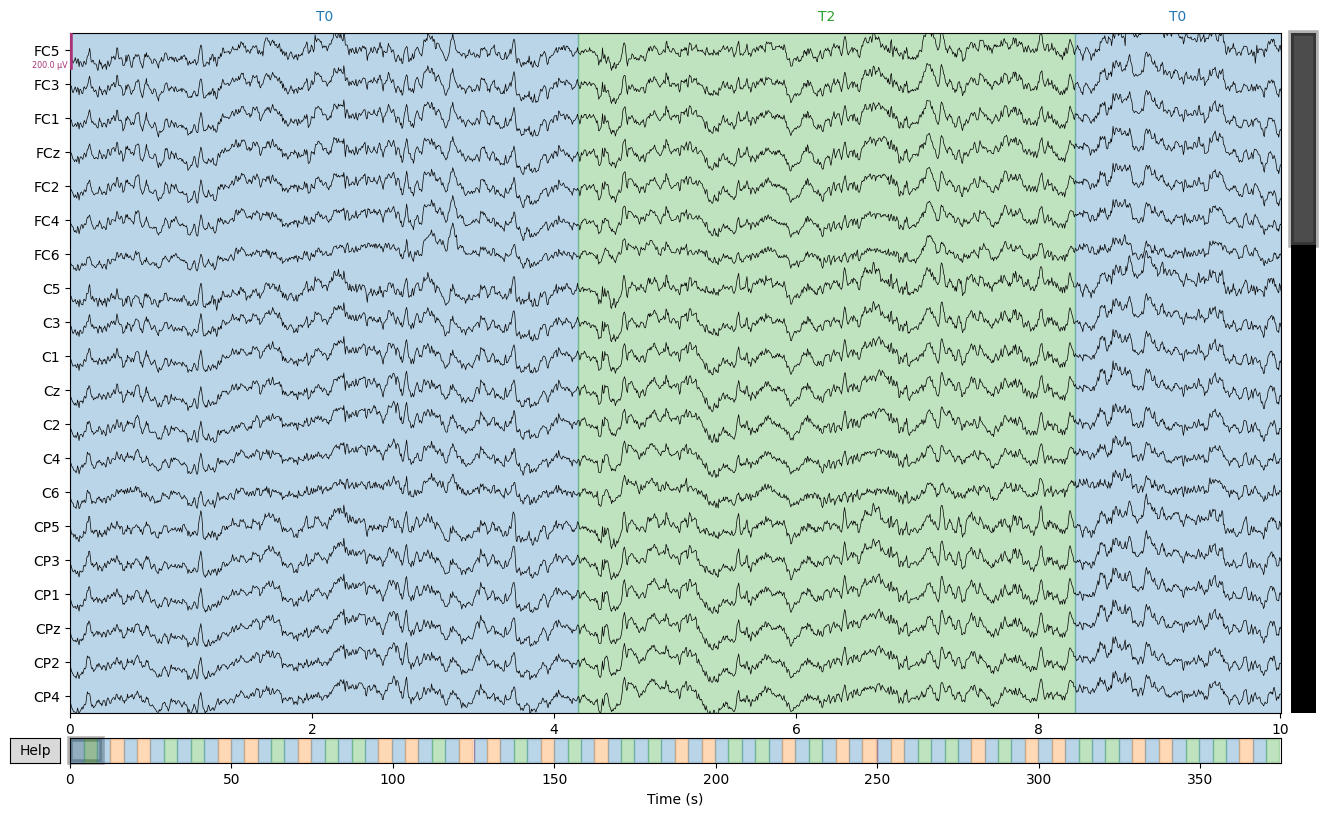

In [9]:
_ = raw.plot(scalings=dict(eeg=1e-4)) # 1e-3 makes frequencies too flat, while 1e-5 make it to sturdy

:arrow_up: tension au cours du temps par electrode\
And what are T0, T2 etc....? According to [this page](https://physionet.org/content/eegmmidb/1.0.0/):
- T0 corresponds to rest
- T1 corresponds to onset of motion (real or imagined) of:
    - the left fist (in runs 3, 4, 7, 8, 11, and 12)
    - both fists (in runs 5, 6, 9, 10, 13, and 14)
- T2 corresponds to onset of motion (real or imagined) of
    - the right fist (in runs 3, 4, 7, 8, 11, and 12)
    - both feet (in runs 5, 6, 9, 10, 13, and 14)


In [10]:
events, _ = events_from_annotations(raw, event_id=dict(T0=0, T1=1, T2=2))
print(f"{str(events)[:100]}...")

[[    0     0     0]
 [  672     0     2]
 [ 1328     0     0]
 [ 2000     0     1]
 [ 2656     0   ...


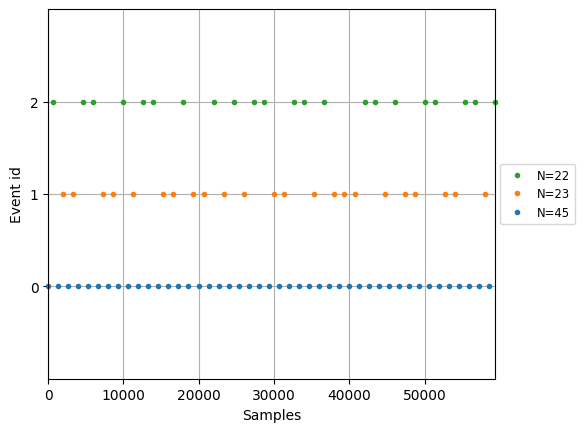

In [11]:
_ = viz.plot_events(events[:100])

# 2. Transform and Filter the data:

So in the previous plots we have a lot to digest...\
we have around 40 channels, each have their own signal curve, so a list of floats corresponding to the intensity of the signal (in Volts) at each seconds of the experiments (up to 350 seconds).\
it would be nice to reduce those dimensions.\
One good way to do it is to compute power spectral density (PSD) of those EEG signals.\
The PSD provides information about the power of the signal at different frequencies, and can be used to identify frequency bands that are relevant for a particular analysis.

### 2.a Compute Power Spectral Density:

/home/deya/Perso/total_perspectiv_vortex/vortex_env/lib/python3.10/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


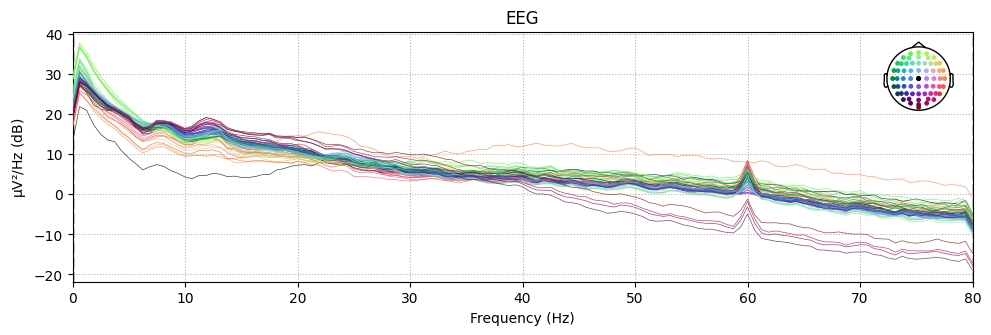

In [12]:
raw.compute_psd().plot()

### 2.b Remove bad and useless channels:

Ok and what to I do with all this data.... ?
> "In EEG data, a good channel refers to an electrode that has recorded useful and reliable signals, while a bad channel refers to an electrode that has recorded noisy or unreliable signals, or no signal at all."

> "Some common reasons for bad channels include electrode malfunction, poor contact between electrode and scalp, excessive muscle or eye movement artifacts, or other types of noise. It is important to identify and mark bad channels in EEG data, as they can have a negative impact on subsequent data analysis."

> "In the MNE library, bad channels can be identified visually by inspecting the raw data or by using automated algorithms such as signal-to-noise ratio (SNR) or correlation-based methods. Once identified, bad channels can be interpolated (i.e., estimated based on neighboring electrodes) or removed from further analysis."

We should remove all the bad channels.\
let's see if we have any:

In [13]:
raw.info['bads']

[]

Hum ok, so if we don't have bad channels, we can at least remove useless channels:
- `AF7, AF3, AFz, AF4, AF8`: these channels are located in the anterior frontal region and are not related to the motor cortex.
- `Fp1, Fpz, Fp2`: these channels are located in the prefrontal region and are not directly related to the motor cortex.
- `P7, P5, P3, P1, P2, P4, P6, P8`: these channels are located in the parietal region and are less relevant for motor imagery tasks.
- `PO7, PO3, POz, PO4, PO8`: these channels are located in the occipital region and are not related to the motor cortex.
- `Iz`: this channel is located at the top of the head and is not directly related to the motor cortex.

In [14]:
useless_channels = ['AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'Fp1', 'Fpz', 'Fp2', 'P7', 'P5', 'P3', 'P1', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'Iz']

In [15]:
picks = pick_types(raw.info, eeg=True,
                   exclude=useless_channels)
raw = raw.pick(picks)

/home/deya/Perso/total_perspectiv_vortex/vortex_env/lib/python3.10/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


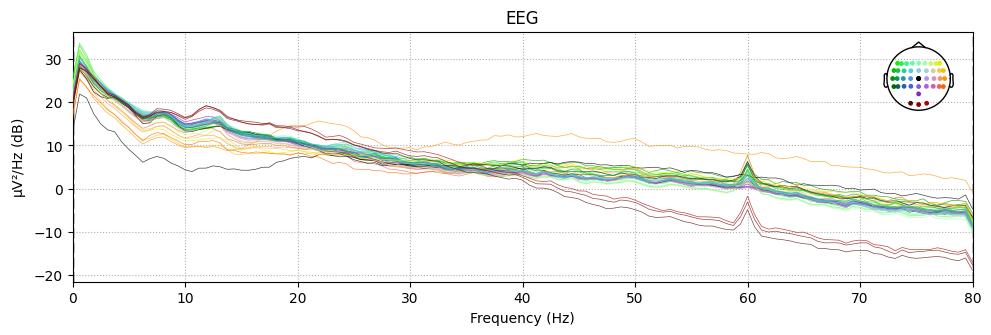

In [16]:
raw.compute_psd().plot()

### 2.c Reduce Noise:

>A notch filter is a type of filter used to remove a specific frequency band from a signal. In this case, the notch filter is being applied to remove the power line noise at a frequency of 60 Hz. Power line noise is a type of interference that can be picked up by EEG electrodes due to the electrical activity of nearby power lines.\
>The notch filter is applied to remove this specific frequency band because it is not relevant to the EEG signal and can interfere with the analysis of other frequency bands. By removing the power line noise at 60 Hz, the signal-to-noise ratio of the EEG signal can be improved, and the analysis of other frequency bands can be more accurate.


/home/deya/Perso/total_perspectiv_vortex/vortex_env/lib/python3.10/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


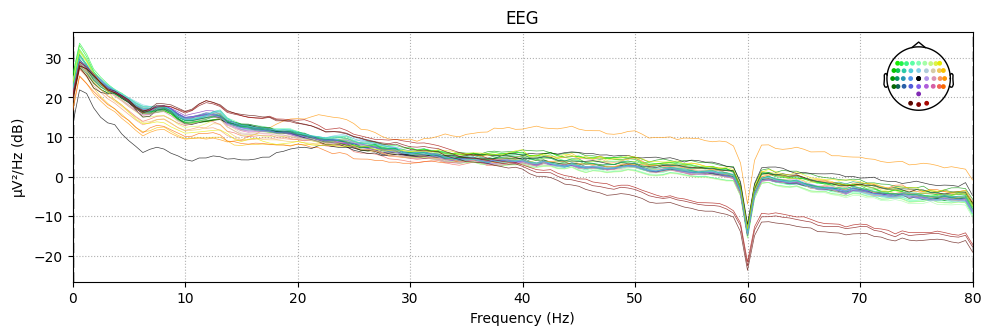

In [17]:
raw.notch_filter(60, method="iir")
raw.compute_psd().plot()

### 2.d Focus on what matters to us: motor imagery task (~8-40Hz)

/home/deya/Perso/total_perspectiv_vortex/vortex_env/lib/python3.10/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


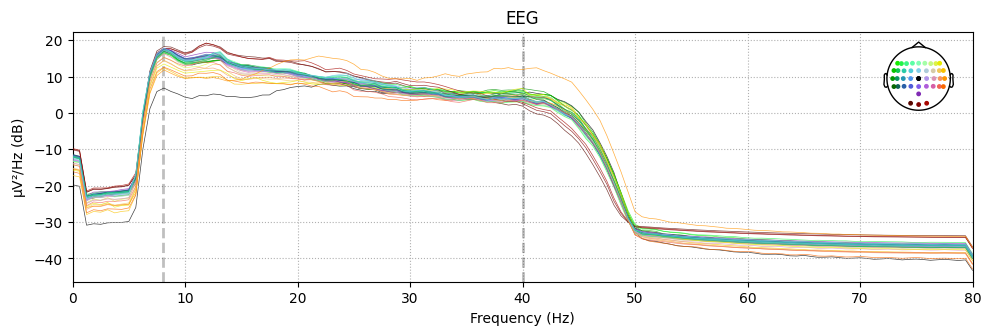

In [18]:
raw.filter(8.0, 40.0)
raw.compute_psd().plot()

### 3.d Clean the signal:

ie: Repartition de la puissance du signal en fonction des bandes de frequences

/home/deya/Perso/total_perspectiv_vortex/vortex_env/lib/python3.10/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


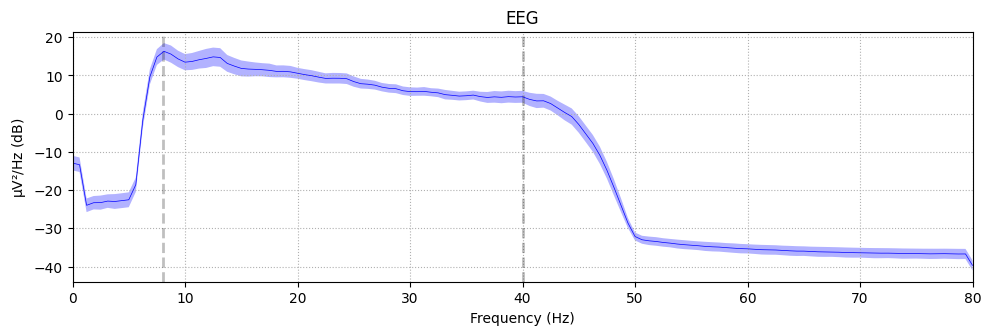

In [19]:
raw.compute_psd().plot(average=True, color='blue')